## Detailed Description:

This project focuses on evaluating the accuracy of a machine learning model, dealing with overfitting, and exploring techniques for regularization. The dataset used is related to athletes, and the goal is to apply logistic regression, handle potential overfitting issues, and assess the model's performance using metrics such as ROC-AUC.

### Step 1: Importing Necessary Libraries

In [152]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [153]:
import warnings
warnings.filterwarnings('ignore')

### Step 2: Reading the Dataset

In [154]:
df = pd.read_csv('материалы/athletes.csv')

In [155]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


### Step 3: Data Preprocessing

Missing values are identified and removed using .dropna(), and duplicate records are dropped with .drop_duplicates(). The .info() function is used to verify the structure of the cleaned dataset.

In [157]:
df.isna().sum()

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [158]:
df = df.dropna()
df = df.drop_duplicates()

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


### Step 4: Feature Engineering

Certain categorical features like nationality, sex, and sport are converted into categorical types. The date of birth (dob) column is also transformed into a datetime format.

In [160]:
df["nationality"] = df["nationality"].astype("category")
df["sex"] = df["sex"].astype("category")
df["sport"] = df["sport"].astype("category")
df['dob'] = pd.to_datetime(df['dob'], format='%m/%d/%y')

### Step 5: Calculating Age

A function is defined to calculate the athletes' ages based on their date of birth.

In [161]:
def calculate_age(birth_date):
    today = datetime.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

In [162]:
df['dob'] = df['dob'].apply(calculate_age).astype(int)

In [163]:
df['total_medals'] = df['gold'] + df['silver'] + df['bronze']
df['has_medal'] = (df['total_medals'] > 0).astype(int)

### Step 6: Splitting the Data into Train and Test Sets

In [165]:
y = df['has_medal']
X = df[df.columns[2:-5]]

In [166]:
X = pd.get_dummies(X, columns=['nationality', 'sex', 'sport'])

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Step 7: Training the Logistic Regression Model

In [168]:
model = LogisticRegression()

In [169]:
model.fit(X_train, y_train)

LogisticRegression()

### Step 8: Evaluating Model Performance

In [170]:
predictions = model.predict(X_test)

In [171]:
recall_score(y_test, predictions)

0.030470914127423823

In [172]:
precision_score(y_test, predictions)

0.3793103448275862

Recall indicates the proportion of actual positive instances that were correctly identified by the model. In this case, the recall is very low (0.03), meaning the model only correctly predicted about 3% of the actual positive cases. This suggests that the model is significantly underestimating the positive class.

Precision measures the proportion of positive predictions made by the model that are actually correct. Here, precision is around 37.93%, which indicates that the model is relatively prone to predicting false positives (incorrectly labeling negative instances as positive).

The model demonstrates poor recall, suggesting a serious issue in identifying the positive class. The precision is slightly better, but still, the model requires improvement. This could point to class imbalance or the model being overfitted or underfitted.

### Step 9: ROC Curve and AUC Score

In [174]:
y_scores = model.predict_proba(X_test)[:, 1]

In [175]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

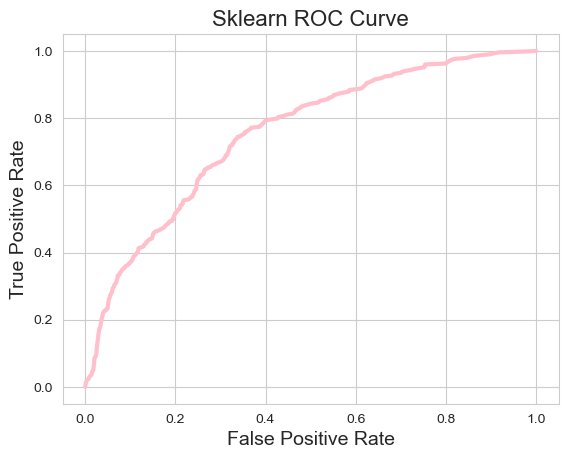

In [176]:
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, y_scores)
sns.lineplot(x=fpr_sklearn, y=tpr_sklearn, lw=3, color='pink')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Sklearn ROC Curve', fontsize=16)
plt.grid(True)
plt.show()

The ROC curve shows how the values of TPR and FPR change as the decision threshold of the classifier is adjusted. An ideal model would have a point in the upper left corner of the graph (where FPR = 0, TPR = 1), indicating no errors. The closer the curve is to the top left corner, the better the model.

In [178]:
auc = roc_auc_score(y_test, y_scores)
print(f"ROC-AUC: {auc}")

ROC-AUC: 0.7538954771624927


With an AUC of around 0.7539, the model demonstrates moderate quality, meaning it more often correctly classifies positive and negative classes than it makes errors. However, there is room for improvement since this value is not approaching 1, which would indicate ideal performance.

### Implementation of calculation of TPR, FPR metrics "manually", without using ready-made functions from the sklearn library.

In [180]:
def calculate_tpr_fpr(y_test, y_scores, threshold=0.5):

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for true, score in zip(y_test, y_scores):
        if score >= threshold:
            if true == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true == 1:
                FN += 1
            else:
                TN += 1

    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    
    return tpr, fpr

Plotting ROC curve using manually calculated TPR, FPR metrics

In [182]:
def manual_roc_curve(y_test, y_scores):
    thresholds = np.linspace(0, 1, 100)
    tpr_values = []
    fpr_values = []

    for threshold in thresholds:
        tpr, fpr = calculate_tpr_fpr(y_test, y_scores, threshold)
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return fpr_values, tpr_values, thresholds

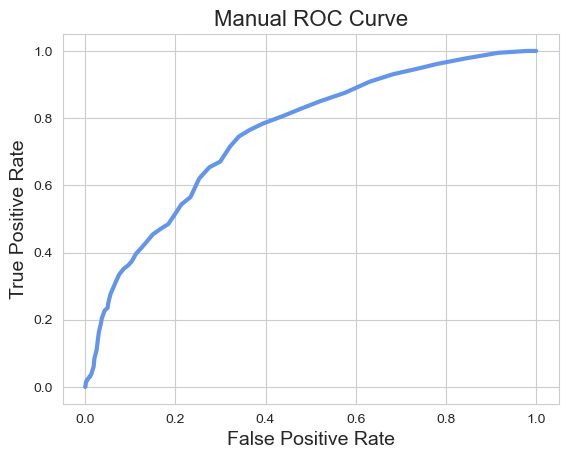

In [183]:
fpr_manual, tpr_manual, thresholds_manual = manual_roc_curve(y_test, y_scores)
sns.lineplot(x=fpr_manual, y=tpr_manual, lw=3, color='cornflowerblue')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Manual ROC Curve', fontsize=16)
plt.grid(True)
plt.show()

Combine ROC graphs

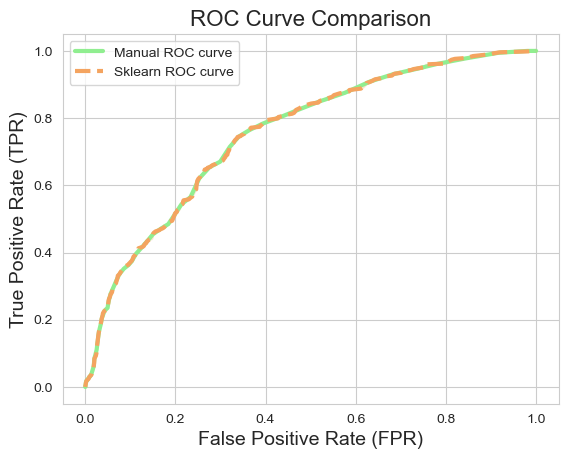

In [185]:
sns.lineplot(x=fpr_manual, y=tpr_manual, label='Manual ROC curve',lw=3, color='lightgreen')
sns.lineplot(x=fpr_sklearn, y=tpr_sklearn, label='Sklearn ROC curve',lw=3, color='sandybrown', linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

It can be seen that they are basically the same

### Plot Precision-Recall graph using TPR, FPR metrics calculated manually

In [188]:
tpr_array = np.array(tpr_manual)
fpr_array = np.array(fpr_manual)

In [189]:
precision = tpr_array / (tpr_array + fpr_array)
recall = tpr_array

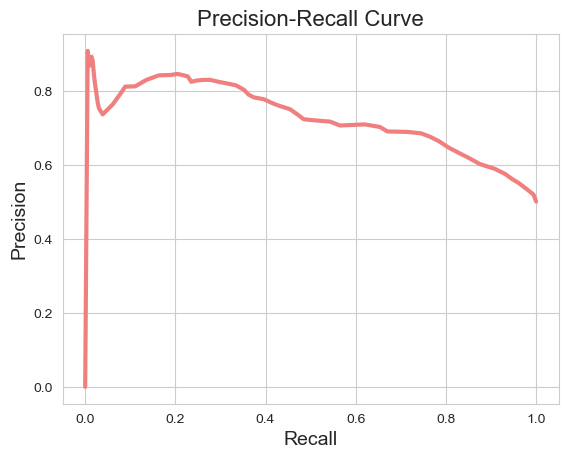

In [190]:
sns.lineplot(x=recall, y=precision, lw=3, color='lightcoral')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.grid(True)
plt.show()

Initially, at very low recall (around 0), precision is high because the model predicts very few positive instances, and most of them are correct. As recall increases, the model starts identifying more positive instances, but precision gradually decreases. This happens because, as the model predicts more positive cases, it also starts making more false positive predictions.

The model demonstrates a decent balance between precision and recall for moderate recall values (around 0.4 to 0.8), which can be seen as a positive sign.
However, at higher recall values (above 0.8), precision starts dropping significantly, indicating that the model makes more errors in attempting to identify all positive cases.

## Conclusions:

In this project, logistic regression was applied to predict the gender of athletes based on their age, height, and weight. After cleaning and preparing the dataset, the model achieved a reasonable precision, recall, and AUC score. To combat overfitting, L2 regularization was introduced, which improved the model's generalization ability. The ROC curve visualized the trade-off between true positive and false positive rates.